<a href="https://colab.research.google.com/github/COGS118A/Group004-Sp22/blob/main/Checkpoint_group004.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COGS 118A- Project Checkpoint

# Names

- Daniel Milton
- Isabella Gonzalez
- Dhruva Kolikineni
- Harini Adivikolanu
- Brandon Rocchio

# Abstract 
Classification involves predicting discrete class labels for unlabeled data. given information on the data. The data we are working with is information from individuals' shopping trips at Walmart. The data is broken down into 7 observations, one of which is the trip type which tells us what type of shopping trip this customer was on, visit number which organizes the data into individual shopping trips, weekday that the trip was done on, UPC number of the item purchased, department of purchase and the fineline number which is a number that Walmart made helping us specify the items purchased. Given certain data such as what weekday it is, what department it was in, and what the UPC was, our goal is to be able to predict what type of shopping trip someone was on based off of a couple pieces of data.



# Background

Although supervised classification methods have been studied greatly throughout the years, research specific to this problem, on classifying a grocery trip based on the items bought remains low. There are multiple classification algorithms we can attempt in order to classify the 38 different types of shopping trips there are. K-nearest neighbors, decision trees, random forest classifiers, neural networks and logistic regression are commonly used in order to solve classification problems. Due to the low amount of research done in this specific problem area, this background section will be a small literature review of potential classification algorithms to use for our problem.

Firstly, K Nearest Neighbors works based on the idea that for a target variable, the k number of patterns nearest to that target variable can provide useful information in order to properly classify the target variable. KNN assigns the target variable the classification of the majority of the nearest neighbors<a name="first"></a>[<sup>[1]</sup>](#firstnote). The downfalls of KNN are that there is no right 'K' to choose and it can be computationally inefficient. Second, Decision Trees are another classification method we want to attempt, these are popular due to their good accuracy scores and their computational efficiency<a name="second"></a>[<sup>[2]</sup>](#secondnote). The random forest classifier works by using multiple tree classifiers where each classifier is generated by using a random vector and each tree vottes for the most 'popular' class to classify an input vector<a name="third"></a>[<sup>[3]</sup>](#thirdnote). This paper uses random forests to classify remote sensing which they concluded was just as accurate as using a support vector machine.

Neural Networks and logistic regression are other potential algorithms we would like to try to classif our data with, there was no literature on any similar classification task to our project but a paper revealed that these two algorithms share common roots in statistical pattern recognition and that neural networks can be seen as a type of generalization from logistic regression<a name="fourth"></a>[<sup>[4]</sup>](#fourthnote). Lastly, upon multiple attempts to find related work, Cui et al attempted this trip type classification using deep embedding logistic regression which incorporates logistic regression into a deep and narrow neural network<a name="fifth"></a>[<sup>[5]</sup>](#fifthnote). We are hoping as we implement some of these algorithms to produce results and a discussion that can help future research for stores like Walmart to improve customers' shopping experiences or help understand/solve problems similar to this.

# Problem Statement

Walmart currently employs a proprietary method to catogorize shopping trips into 38 distinct types. We have set out to create a clustering/catagorization model that, given a limited set of customer behavior features, predicts the shopping trip types.

As an example for what these trip types may be: a customer may make a small daily dinner trip, a weekly large grocery trip, a trip to buy gifts for an upcoming holiday, or a seasonal trip to buy clothes.

#Setup

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import *
import io

# Data

UPDATED FROM PROPOSAL!

You should have obtained and cleaned (if necessary) data you will use for this project.

Please give the following infomration for each dataset you are using
- link/reference to obtain it
- description of the size of the dataset (# of variables, # of observations)
- what an observation consists of
- what some critical variables are, how they are represented
- any special handling, transformations, cleaning, etc you have done should be demonstrated here!


In [2]:
## Uploading train.csv
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


# Data Preprocessing:

##Cleaning the data:

In [3]:
## Load in train dataset
train = pd.read_csv(io.BytesIO(uploaded['train.csv']))

## Drop Upc column
train.drop(columns=['Upc'], inplace = True)


## Find all rows with null values
null_vals = train[train.isna().any(axis=1)]

## I found from the above code that there is 4129 rows
## with null values. From this I found that Department Descriptions of
## PHARMACY RX always has a null FinelineNumber


## A check of all unique values in these columns to make sure if any
## further cleaning of the strings is needed
department_unique = train['DepartmentDescription'].unique()
weekday_unique = train['Weekday'].unique()
scancount_unique = train['ScanCount'].unique()

## Function to change the week days to quantitative variables, which allows us
## to do analysis on the Weekday column
def weekday_int_converter(x):
  if x=='Monday':
    return 0
  elif x=='Tuesday':
    return 1
  elif x=='Wednesday':
    return 2
  elif x=='Thursday':
    return 3
  elif x=='Friday':
    return 4
  elif x=='Saturday':
    return 5
  elif x=='Sunday':
    return 6 


train['Weekday'] = train['Weekday'].apply(weekday_int_converter)

## Filtered the train csv of all null values in the Department 
## Description column
train = train[train['DepartmentDescription'].notna()]


## I found there to be 60367 duplicate rows.
duplicates = train[train.duplicated()]

## Here I made a new df with all the duplicate rows dropped
train_duplicates_dropped = train.drop_duplicates()


## Might be useful to test model on both the original dataframe and the 
## dataframe with the duplicates dropped
## Add a column indicated if the trip includes return
train['Return'] = train['ScanCount']
train
def convert(x):
    if x >= 0:
        return 0
    else:
        return 1
train['Return'] = train['ScanCount'].apply(convert)
train
## Test any variable to see results
train.head()

,TripType,VisitNumber,Weekday,ScanCount,DepartmentDescription,FinelineNumber,Return
0,999,5,4,-1,FINANCIAL SERVICES,1000.0,1
1,30,7,4,1,SHOES,8931.0,0
2,30,7,4,1,PERSONAL CARE,4504.0,0
3,26,8,4,2,PAINT AND ACCESSORIES,3565.0,0
4,26,8,4,2,PAINT AND ACCESSORIES,1017.0,0


## Final Test Set 
We will reserve 10% of our data for final validation. This will serve as our overall task performance benchmark.

##Partitioning Train/Test Sets:
Train/Test splitting will be implemented using Kfold. Since we are working with a very large dataset (500k+ datapoints), we will keep our K value small at K=5. This means each fold will have ~20% of our data in each fold. 

# Proposed Solution

Our proposed solution is to use train and fit a model to the traiing data and evaluate its perfromance on the testing data, all the whiel using cross validation to verify the accuracy of our results.

The model we intend on using is still up for our team to decide, but given the nature of the problem of non-binary classification into 38 distinct catagories, we have isolated some models we beileve might be best suited for the task:

- K- Nearest Neighbors
- Decision tree classifiers
- Neural Networks
- Random Forest Classifiers

# Preliminary results

NEW SECTION!

Please show any preliminary results you have managed to obtain.

Examples would include:
- Analyzing the suitability of a dataset or alogrithm for prediction/solving your problem 
- Performing feature selection or hand-designing features from the raw data. Describe the features available/created and/or show the code for selection/creation
- Showing the performance of a base model/hyper-parameter setting.  Solve the task with one "default" algorithm and characterize the performance level of that base model.
- Learning curves or validation curves for a particular model
- Tables/graphs showing the performance of different models/hyper-parameters



##EDA:

Before exploring the distributions of the data, we found that there were 38 different unique trip type categories in our dataset and plotted their frequency.

In [4]:
#taking first look at data
train.TripType.unique()
train['TripType'].value_counts()

40     173973
39      95382
37      38886
38      29528
25      27499
7       23170
8       22776
36      21963
44      20364
42      19419
24      17967
999     17343
9       16741
5       13823
32      13812
35      12492
33       9902
15       7126
3        6822
43       6363
41       5491
30       4846
34       4741
27       4601
21       4025
22       3581
6        3402
20       3110
18       2971
28       2659
26       2503
12       2104
29       2100
31       1761
19       1187
4         900
23        325
14         35
Name: TripType, dtype: int64

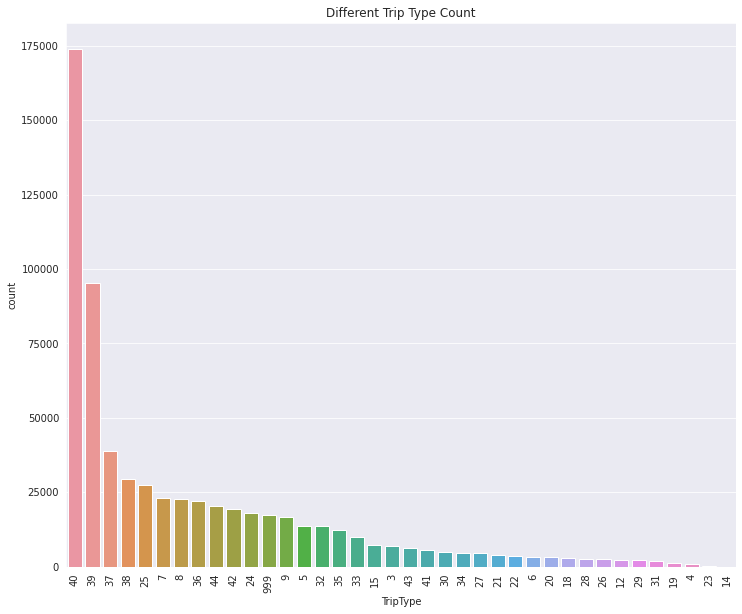

In [5]:
#plotting trip type frequency
plt.figure(figsize = (12, 10))
sns.set_style('darkgrid')
sns.countplot(x = 'TripType', data = train, order = train['TripType'].value_counts().index).set(title='Different Trip Type Count')
plt.xticks(rotation=90)
sns.set(font_scale=2)

We then did the same for department description and found that there were 68 different descriptions.

In [6]:
train.DepartmentDescription.unique()
train.DepartmentDescription.value_counts()

GROCERY DRY GOODS         70402
DSD GROCERY               68332
PRODUCE                   51115
DAIRY                     43820
PERSONAL CARE             41969
                          ...  
LARGE HOUSEHOLD GOODS        77
CONCEPT STORES               35
OTHER DEPARTMENTS            29
SEASONAL                     29
HEALTH AND BEAUTY AIDS        2
Name: DepartmentDescription, Length: 68, dtype: int64

To deduce whether there was a relationship between the department description and trip type, we plotted the frequency of the top 10 departments from which shoppers bought products from versus the trip type number. We found that trip types 40, 39, 37, 38, 7, and 8 seemed to be grocery trips of some sort, while trip types 36, 44, and 42 seemed to be household supply runs of some sort. Thus, it will be important to consider another factors like weekday vs. weekend, return vs. purchase, or the specific products purchased to differentiate trip types that seem to be overlapping like grocery/household trips.

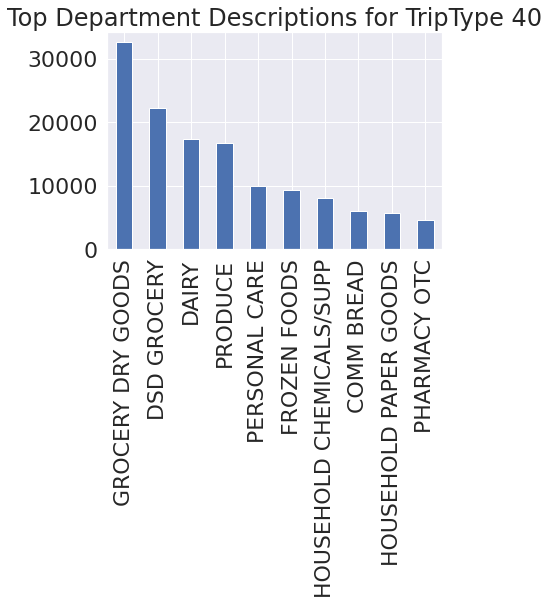

In [7]:
#TripType 40 seems to be a grocery trip type
triptype_40 = train[train.TripType == 40].DepartmentDescription.value_counts().head(10).plot(kind = 'bar', title = 'Top Department Descriptions for TripType 40')

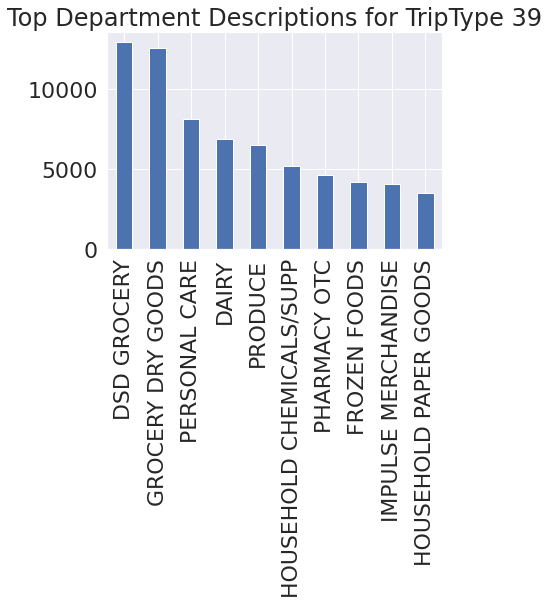

In [8]:
#TripType 39 seems to be a grocery trip type/household trip
triptype_39 = train[train.TripType == 39].DepartmentDescription.value_counts().head(10).plot(kind = 'bar', title = 'Top Department Descriptions for TripType 39')

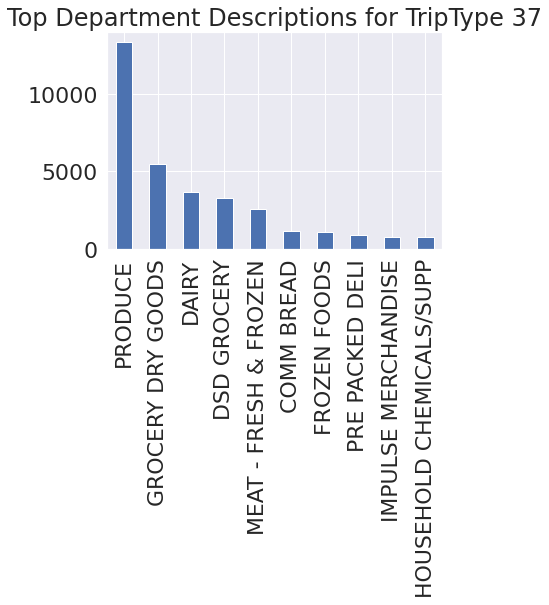

In [9]:
#TripType 37 seems to be a grocery trip type - meat + frozen goods?
triptype_37 = train[train.TripType == 37].DepartmentDescription.value_counts().head(10).plot(kind = 'bar', title = 'Top Department Descriptions for TripType 37')

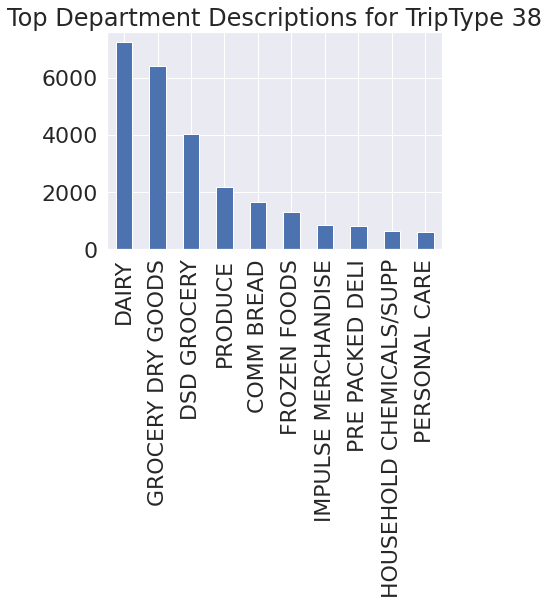

In [10]:
#TripType 38 seems to be a grocery trip type
triptype_38 = train[train.TripType == 38].DepartmentDescription.value_counts().head(10).plot(kind = 'bar', title = 'Top Department Descriptions for TripType 38')

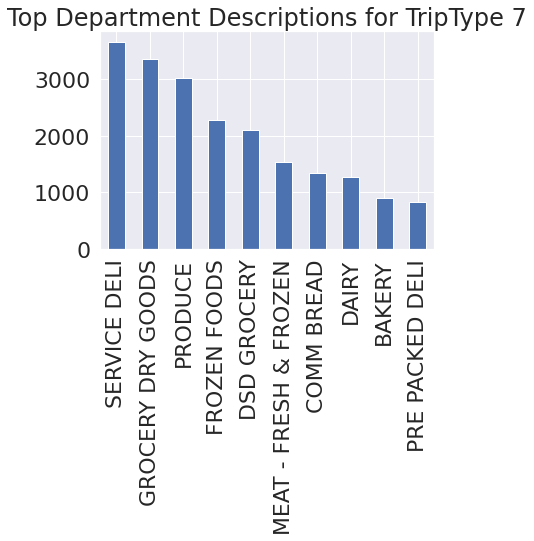

In [11]:
#TripType 7 seems to be a grocery trip type
triptype_7 = train[train.TripType == 7].DepartmentDescription.value_counts().head(10).plot(kind = 'bar', title = 'Top Department Descriptions for TripType 7')

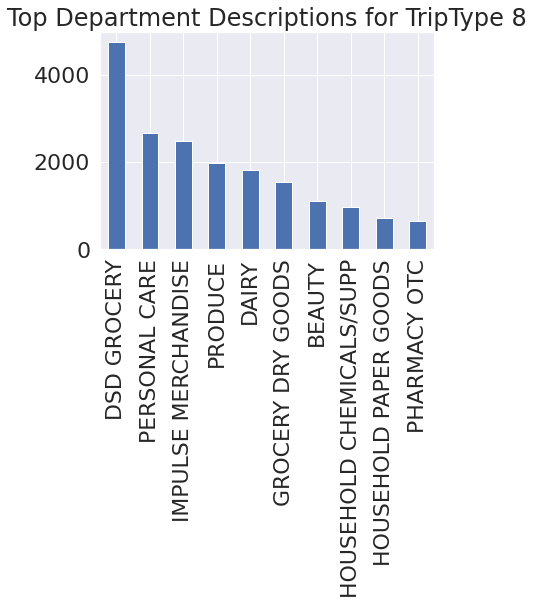

In [12]:
#TripType 8 seems to be a quick grocery run/errand run?
triptype_8 = train[train.TripType == 8].DepartmentDescription.value_counts().head(10).plot(kind = 'bar', title = 'Top Department Descriptions for TripType 8')

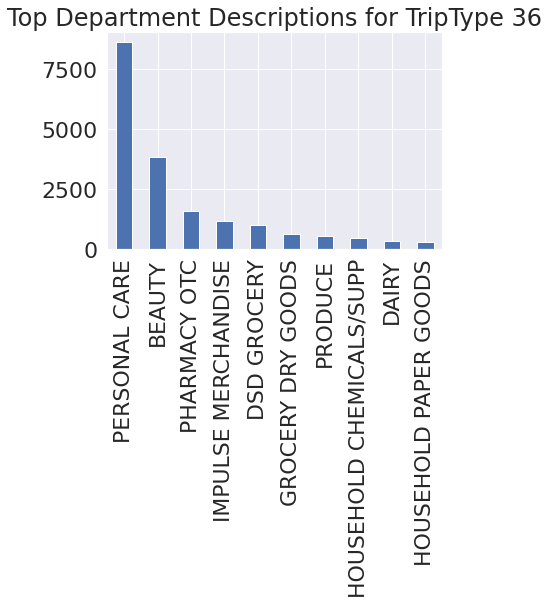

In [13]:
#TripType 36 seems to be a household/personal care run
triptype_36 = train[train.TripType == 36].DepartmentDescription.value_counts().head(10).plot(kind = 'bar', title = 'Top Department Descriptions for TripType 36')

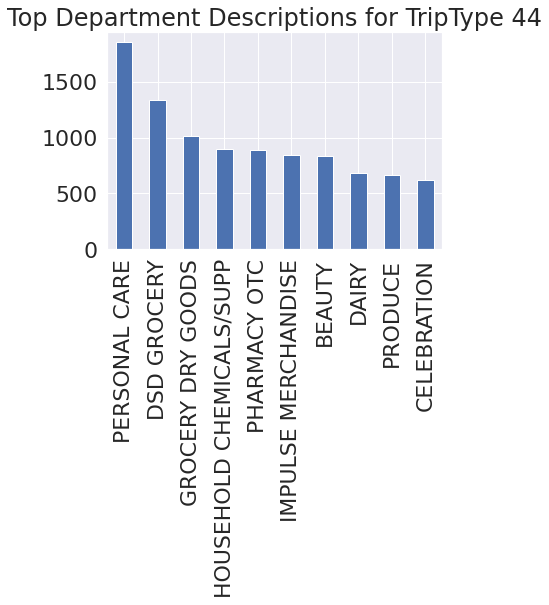

In [14]:
#TripType 44 seems to be a household run
triptype_44 = train[train.TripType == 44].DepartmentDescription.value_counts().head(10).plot(kind = 'bar', title = 'Top Department Descriptions for TripType 44')

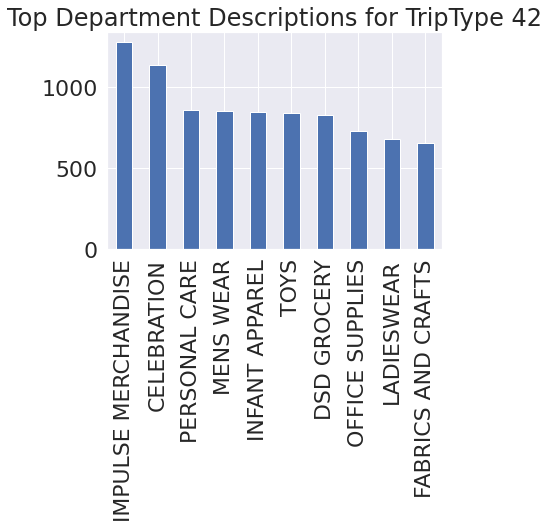

In [15]:
#TripType 42 seems to be a household run
triptype_42 = train[train.TripType == 42].DepartmentDescription.value_counts().head(10).plot(kind = 'bar', title = 'Top Department Descriptions for TripType 42')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]),
 <a list of 68 Text major ticklabel objects>)

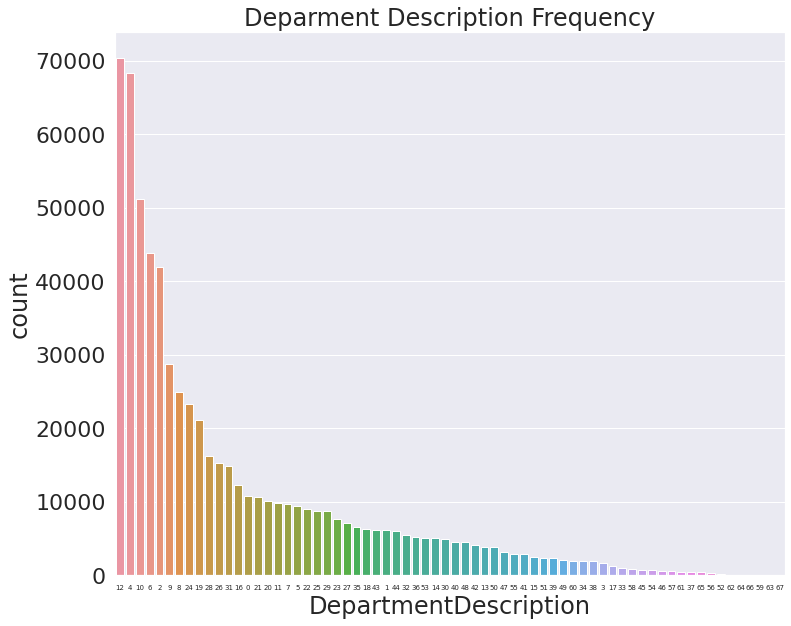

In [16]:
#plotting department description frequency
## Creating a dictionary to convert department descriptions to ints
department_list=list(train['DepartmentDescription'].unique())
department_enumerate=list(enumerate(department_list))
department_dict={v:k for k,v in department_enumerate}
train.replace({'DepartmentDescription': department_dict},inplace=True)


## Plotting
plt.figure(figsize = (12, 10))
sns.set_style('darkgrid')
sns.countplot(x = 'DepartmentDescription', data = train, order = train['DepartmentDescription'].value_counts().index).set(title='Deparment Description Frequency')
plt.xticks(fontsize=7)

To start exploring these other factors, we analyzed the frequency of trips made on each weekday and created a pivot table to conduct a bivariate analysis between TripType and Weekday. This allowed us to visualize the probability that a certain TripType falls on a certain day. Interestingly, we found that TripType frequency seemed similar throughot the week, regardless of the weekday.

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

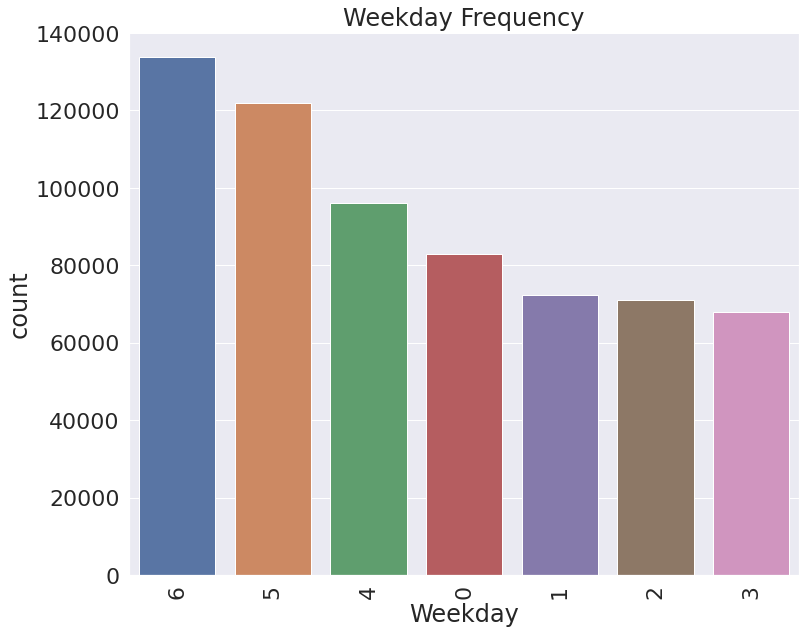

In [17]:
#plotting weekday frequency
plt.figure(figsize = (12, 10))
sns.set_style('darkgrid')
sns.countplot(x = 'Weekday', data = train, order = train['Weekday'].value_counts().index).set(title='Weekday Frequency')
plt.xticks(rotation=90)

In [18]:
## Creating a pivot table to do bivariate analysis between TripType and
## Weekday
Weekday_TripType = (
   train
    .pivot_table(index='TripType', columns='Weekday', values=None, aggfunc='size').fillna(0)
)


## calculating all the probabilities of getting a certain trip type,
## depending on the day of the week
for i in Weekday_TripType:
    Weekday_TripType[i] = Weekday_TripType[i] / Weekday_TripType[i].sum()
    
## Here I removed trip type 999 because it skewed our graph
Weekday_TripType = Weekday_TripType[:-1]
Weekday_TripType

Weekday,0,1,2,3,4,5,6
TripType,,,,,,,
3,0.010008,0.011885,0.012626,0.011202,0.014658,0.009577,0.006740
4,0.001338,0.001327,0.001677,0.001562,0.001593,0.001346,0.001130
5,0.021848,0.025607,0.028126,0.026841,0.022695,0.019359,0.013480
6,0.004051,0.004851,0.005425,0.005572,0.006819,0.007017,0.003307
7,0.039694,0.041016,0.045613,0.042140,0.033668,0.029306,0.029991
8,0.037632,0.041320,0.040907,0.042656,0.037124,0.029650,0.027597
9,0.024381,0.024903,0.028577,0.029847,0.028754,0.025908,0.022031
12,0.002496,0.002515,0.001592,0.001356,0.003082,0.005441,0.004122
14,0.000169,0.000000,0.000000,0.000000,0.000083,0.000107,0.000000


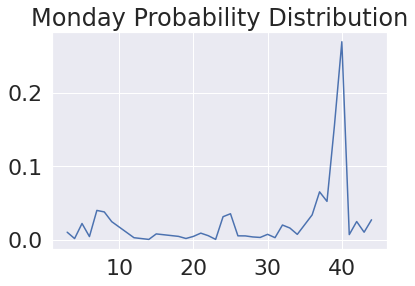

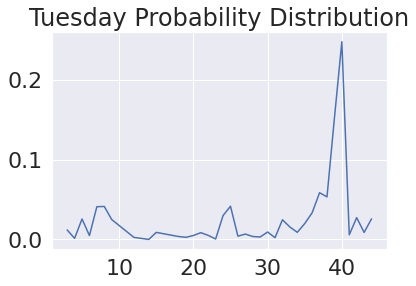

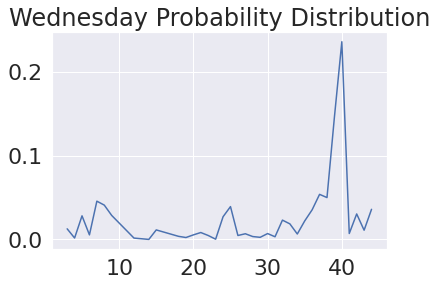

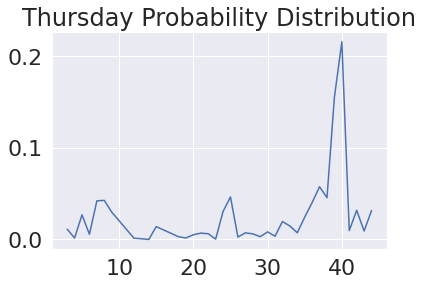

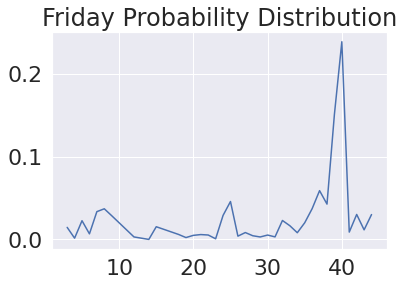

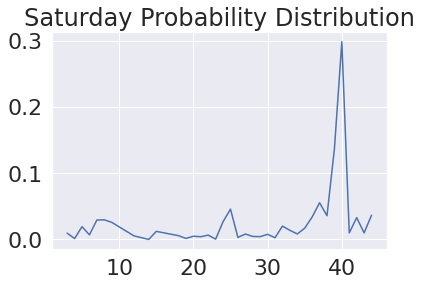

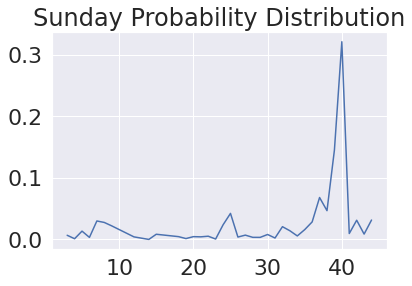

In [19]:
## Here I used a for loop to plot the 
## Probabilies depending on the trip type
## for every day of the week. Here we can 
## see that trip types remain very similiar across
## the week days. This might be useful to consider when we decide how
## much weight to give weekdays in our model.
weekdays = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday',}
for i in Weekday_TripType:
    plt.figure()
    plt.plot(Weekday_TripType.index, Weekday_TripType[i])
    plt.title(weekdays[i] + ' Probability Distribution')

In [20]:
category_counter = train.copy()
category_counter.fillna(0, inplace = True)
department_list=list(train['DepartmentDescription'].unique())
department_enumerate=list(enumerate(department_list))
department_dict={v:k for k,v in department_enumerate}
df = pd.DataFrame(index = train['VisitNumber'], columns = train['DepartmentDescription'].unique())
df.fillna(0, inplace = True)
def converter(x):
    return str(x) + ','
def converter2(x):
    return x.split(',')[:-1]
category_counter['DepartmentDescription'] = category_counter['DepartmentDescription'].apply(converter)
lists = category_counter.groupby('VisitNumber')['DepartmentDescription'].sum().apply(converter2)
df = df.drop(df.columns[9], axis = 1)
for i in lists.index[:500]:
    for j in lists[i]:
        df.loc[i, j] + 1
mytestgrouped_categories_norm = (df - df.mean()) / (df.max() - df.min())

KeyError: ignored

In [ ]:
a4_dims = (13, 9)
fig, ax = plt.subplots(figsize=a4_dims)
sns.heatmap(ax=ax, data=mytestgrouped_categories_norm.T, linecolor='lightgrey', linewidths=.00000000000000001)
#heatmap = ax.pcolor(mytestgrouped_categories_norm, cmap=plt.cm.Blues, alpha=0.8)
#ax.set_xticklabels(mytestgrouped_categories.columns, minor=False)
#ax.set_yticklabels(mytestgrouped_categories_norm.index, minor=False)
#ax.invert_yaxis()
ax.xaxis.tick_top()
#ax.set_yticks(np.arange(mytestgrouped_categories_norm.shape[1]) + 1, minor=False)
#ax.set_xticks(np.arange(mytestgrouped_categories_norm.shape[0]) + 1, minor=False)
#plt.xticks(rotation=90)
#plt.rc('xtick', labelsize=10)
plt.title('TripType',y=1.04)

## Base Model 
for a start to our analysis, we are going to take a look at what we beleive to be a "base case" using a Logistic Regression Classifer with a somewhat arbritary l2 regularization. This gives us a metric that we can utilize more exhastive methods to try and beat

In [ ]:
temp = pd.get_dummies(train, columns=['DepartmentDescription'])
temp  = temp.dropna()
temp.isnull().values.any()
temp

In [ ]:
from sklearn.model_selection import train_test_split
X = temp
X = X.drop(columns=['TripType'])
y = temp['TripType']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .75)

In [ ]:
#Logistic Regression and standard scaler pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)  # apply scaling on training data
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])
pipe.score(X_test, y_test)

# Evaluation Metrics

(we need to decide on our multiclass evaluation metric, inital thoughts make me belive we should do f1)Our evaluation metric will involve using a multi-class logarithmic loss fuction. For each row, we will find a set of predicted probabilities for every trip type and apply the logarithmic loss formula. As we optimize our model, we hope to minimize this function as a metric of how well our model is performing.



##Feature Selection
In pursuit of selecting only relevent features for our analysis, we decided to use... (Dimentionality reductuion blah blah PCA analysis)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

Our PCA anaysis revealed the following relevent features:
 *

#Model Training
In search of the optimal model, we will instantiate each of our hypothesized algorithms and perform a hyperparameter sweep on each to select the best parameters. This allows each classifier to put it's best foot forward during their eventual model comparison.

##Pipelineing:

In [ ]:
import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


knn_pipe = make_pipeline(steps=[("standard",StandardScaler),("KNN")])
dt_pipe = make_pipeline(steps=[("standard",StandardScaler)])
NN_pipe = make_pipeline(steps=[("standard",StandardScaler)])
Rforest = make_pipeline(steps=[("standard", StandardScaler])



##K-Nearest Neighbors


##Decision Tree

##Neural Network

## Random Forest

## SVM Classifier??

#Model Comparison

# Ethics & Privacy

Our data does not involve anyones data or identity so it would be difficult to find a breach of ethics or privacy. One ethical dilemma that might arise is the increasing amount of data available to big corporations and how they’re using this big data to fine tune their products to keep the average person consuming even more. It would be good to question whether it is completely ethical for corporations to treat everyone as a number to maximize their profits.

Another note on privacy is the trip type classification labels. 



# Team Expectations 

Put things here that cement how you will interact/communicate as a team, how you will handle conflict and difficulty, how you will handle making decisions and setting goals/schedule, how much work you expect from each other, how you will handle deadlines, etc...

- Arrange bi-weekly meetings that works with everyones schedule
- Use a discord server to communicate with one another
- Make use of project managment software to track progress
- Be mindful of git -pull-push-overwrites such that no code is overwritten or needlessly repeated

# Project Timeline Proposal

UPDATE THE PROPOSAL TIMELINE ACCORDING TO WHAT HAS ACTUALLY HAPPENED AND HOW IT HAS EFFECTED YOUR FUTURE PLANS

| Meeting Date  | Meeting Time| Completed Before Meeting  | Discuss at Meeting |
|---|---|---|---|
| 4/24  |  3:30 PM |  Edit, finalize, and submit proposal; Search for datasets  | Discuss Wrangling and possible analytical approaches; Assign group members to lead each specific part | 
| 5/16  |  9 PM |  Delegate tasks for first checkpoint and discuss wrangling, cleaning, and EDA plan | Import and wrangle data, do some EDA | 
| 5/19  | 9 PM  | Edit and finalize data cleaning and wrangling/EDA  | Review/discuss EDA, debug, and submit checkpoint   |
| 5/23  | 7 PM  | Finalize project/conclusion/discussion | Discuss conclusion   |
| 6/8  | Before 11:59 PM  | NA | Turn in Final Project  |

# Footnotes
<a name="first"></a>1.[^](#firstnote): Oliver Kramer. K Nearest Neighbors. https://link.springer.com/chapter/10.1007/978-3-642-38652-7_2<br> 
<a name="second"></a>2.[^](#secondnote): Srivastava et al. (1999) Parallel Forumlations of Decision Tree Classfication Algorithms. http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.41.7475&rep=rep1&type=pdf<br>
<a name="third"></a>3.[^](#thirdnote): M. Pal (2005).Random forest classifier for remote sensing classification. https://www.tandfonline.com/doi/pdf/10.1080/01431160412331269698?casa_token=e78vG4sBDLcAAAAA:p9nt0mSjEMuazyQsDjprmwIIFt9aNRk9EtF7eKRyNozF6FsAskuvXKrMxnnftOK0xFjlUm5MX9g.<br>
<a name="fourth"></a>4.[^](#fourthnote): Stephan Dreiseitl and Lucila Ohno_Machado. (2002). Logistic regression and artificial neural network classification models: a methodology review. https://www.sciencedirect.com/science/article/pii/S1532046403000340.<br>
<a name="fifth"></a>5.[^](#fifthnote): Cui et al. (2018). Deep Embedding Logistic Regression. https://ieeexplore.ieee.org/document/8588790

